In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/2s/15day_0201_0215.csv", usecols=["ds", "y"], parse_dates=["ds"]
)
print(df.shape)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

(648000, 2)


,ds,y
0,2021-02-01 19:00:00,12.0
1,2021-02-01 19:00:02,7.0
2,2021-02-01 19:00:04,1.0
3,2021-02-01 19:00:06,16.0
4,2021-02-01 19:00:08,19.0


In [3]:
df.tail()

,ds,y
647995,2021-02-16 18:59:50,19.0
647996,2021-02-16 18:59:52,19.0
647997,2021-02-16 18:59:54,19.0
647998,2021-02-16 18:59:56,19.0
647999,2021-02-16 18:59:58,19.0


In [4]:
train = df[df['ds'] < '2021-2-10']
valid = df.copy()
valid["days"] = valid["ds"].apply(lambda x: x.day)
valid = valid.groupby("days")["y"].agg("mean")

In [7]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": 30,
        "batch_size": 64,
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
#         "growth": "logistic",
#         "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)
#     val_mape = np.mean(np.abs((valid_forecast.yhat - valid.y) / valid.y)) * 100

    return val_rmse

In [8]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10)

[I 2021-05-12 14:23:38,671] A new study created in memory with name: no-name-d48b642b-8e5f-4242-aca6-23b9d81da50d
Epoch[30/30]: 100%|██████████| 30/30 [03:44<00:00,  7.49s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 2021-05-12 14:27:27,797] Trial 0 finished with value: 32.75583687370011 and parameters: {'num_hidden_layers': 2, 'learning_rate': 0.0951207163345817, 'changepoints_range': 0.91, 'n_changepoints': 29}. Best is trial 0 with value: 32.75583687370011.
Epoch[30/30]: 100%|██████████| 30/30 [03:37<00:00,  7.24s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 2021-05-12 14:31:10,079] Trial 1 finished with value: 11.358792726465296 and parameters: {'num_hidden_layers': 1, 'learning_rate': 0.016443457513284063, 'changepoints_range': 0.808, 'n_changepoints': 33}. Best is trial 1 with value: 11.358792726465296.
Epoch[30/30]: 100%|██████████| 30/30 [03:51<00:00,  7.72s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]
[I 2021-05-12 14:35:06,697] Trial 2 finished with value: 8.925279089923695 and parame

In [9]:
prophet_params = study.best_params
prophet_params["epochs"] = 30
prophet_params["batch_size"] = 64
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [10]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)

In [11]:
metrics = model.fit(train, freq="1D")

Epoch[30/30]: 100%|██████████| 30/30 [03:34<00:00,  7.15s/it, MSELoss=0.118, MAE=10.5, RegLoss=0]


In [12]:
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

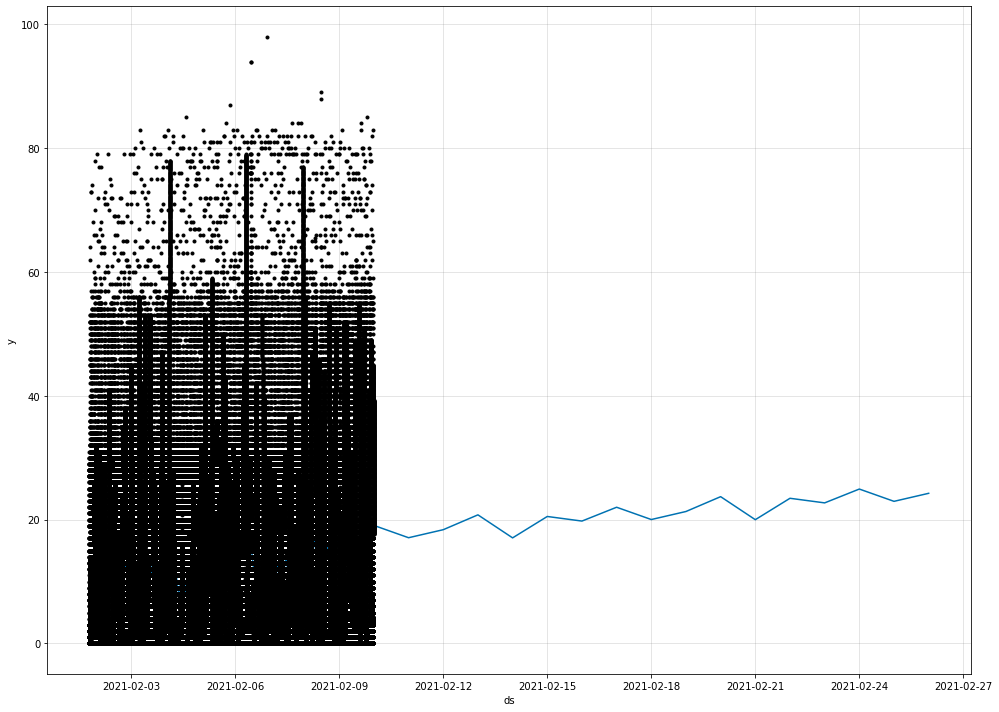

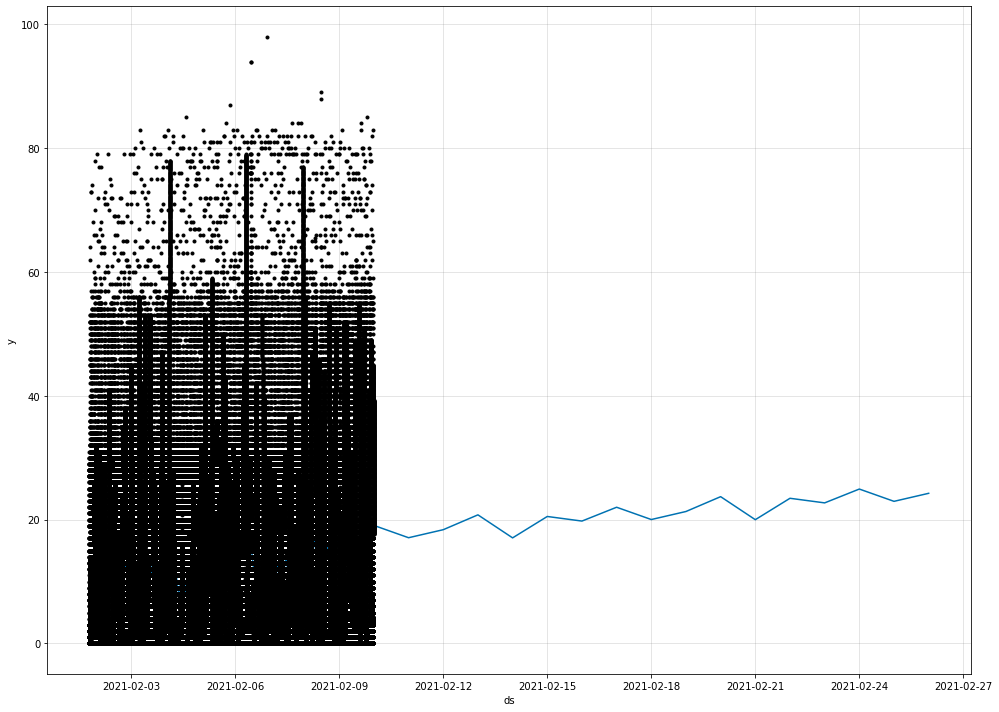

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)

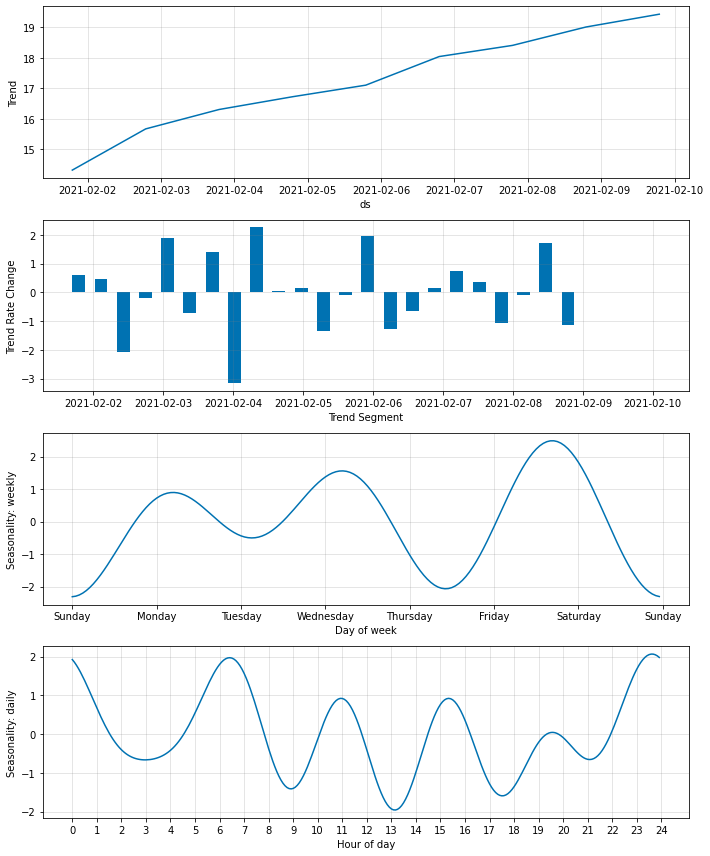

In [14]:
# fig_comp = m.plot_components(forecast)
m = model.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = model.plot_parameters()

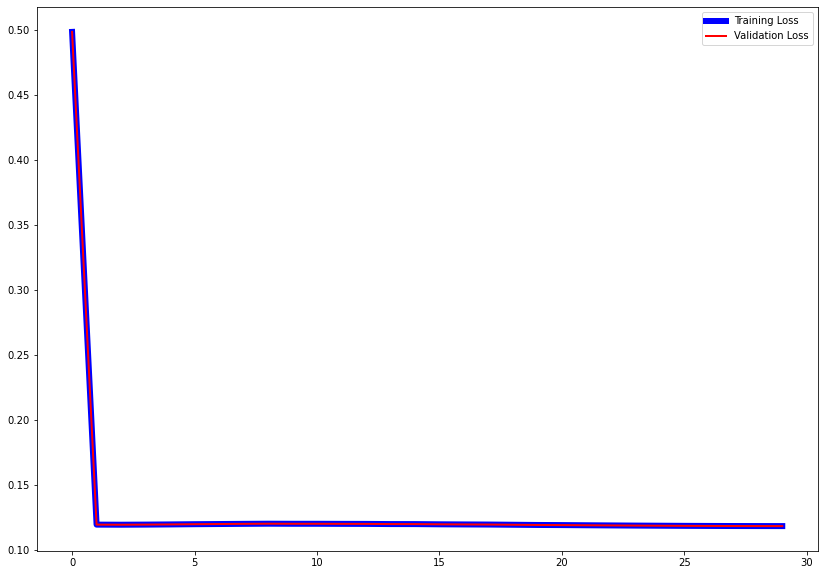

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSELoss"], 'b', linewidth=6, label="Training Loss")  
ax.plot(metrics["MSELoss"], 'r', linewidth=2, label="Validation Loss")
plt.legend()

In [16]:
# # model = NeuralProphet() if you're using default variables below.
# model = NeuralProphet(
#     n_changepoints=5,
#     changepoints_range=0.8,
#     trend_reg=0,
#     trend_reg_threshold=False,
#     yearly_seasonality="auto",
#     weekly_seasonality="auto",
#     daily_seasonality="auto",
#     seasonality_mode="additive",
#     seasonality_reg=0,
#     n_forecasts=1,
#     n_lags=0,
#     num_hidden_layers=0,
#     d_hidden=None,     # Dimension of hidden layers of AR-Net
#     ar_sparsity=None,  # Sparcity in the AR coefficients
#     learning_rate=0.01,
#     epochs=100,
#     loss_func="MSE",
#     normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
#     impute_missing=True,
#     log_level=None, # Determines the logging level of the logger object
# )
# metrics = model.fit(df, freq="D")
# future = model.make_future_dataframe(df, periods=7)
# forecast = model.predict(future)

In [17]:
# fig, ax = plt.subplots(figsize=(14, 10))
# model.plot(forecast, ax=ax)